# 02 Image Captioning
- google colab

## 1. 임포트 & 데이터 로딩
- load encoding_traing
- load encode_model

In [1]:
#CNN(image encoding) : InceptionV3
# from tensorflow.keras.applications.inception_v3 import InceptionV3
# import tensorflow.keras.applications.inception_v3
import tensorflow.keras.preprocessing.image

from tqdm import tqdm
import pickle
from time import time
import numpy as np
from PIL import Image
import json
import os
import string

#RNN(LSTM)
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import (LSTM, Embedding, 
    TimeDistributed, Dense, RepeatVector, 
    Activation, Flatten, Reshape, concatenate,  
    Dropout, BatchNormalization)
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras import Input, layers
from tensorflow.keras import optimizers
from tensorflow.keras import models

from tensorflow.keras.layers import add
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt


In [2]:
#google drive mounting
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [5]:
#set root directory
root = '/content/drive/MyDrive/Final_project/'

In [7]:
#image path, korean & english caption 포함된 json file loading -- 약 12만장 이미지의 데이터
with open(os.path.join(root,'MSCOCO_train_val_Korean.json')) as f:
    json_data = json.load(f)

In [8]:
#train data(index) == [40504:]
json_data = json_data[40504:]

In [9]:
json_filepath = [ path['file_path'] for path in json_data ] #image file path
json_captions = [ path['captions'] for path in json_data ] #english caption

In [10]:
#encodinged images loading

with open(os.path.join(root,'encoding_train_1.pkl'), 'rb') as f:
    encoding_train_1 = pickle.load(f)

with open(os.path.join(root,'encoding_train_2.pkl'), 'rb') as f:
    encoding_train_2 = pickle.load(f)

with open(os.path.join(root,'encoding_train_3.pkl'), 'rb') as f:
    encoding_train_3 = pickle.load(f)

with open(os.path.join(root,'encoding_train_4.pkl'), 'rb') as f:
    encoding_train_4 = pickle.load(f)

with open(os.path.join(root,'encoding_train_5.pkl'), 'rb') as f:
    encoding_train_5 = pickle.load(f)

with open(os.path.join(root,'encoding_train_6.pkl'), 'rb') as f:
    encoding_train_6 = pickle.load(f)

with open(os.path.join(root,'encoding_train_7.pkl'), 'rb') as f:
    encoding_train_7 = pickle.load(f)

with open(os.path.join(root,'encoding_train_8.pkl'), 'rb') as f:
    encoding_train_8 = pickle.load(f)

In [11]:
encoding_train_1.update(encoding_train_2)
encoding_train_1.update(encoding_train_3)
encoding_train_1.update(encoding_train_4)
encoding_train_1.update(encoding_train_5)
encoding_train_1.update(encoding_train_6)
encoding_train_1.update(encoding_train_7)
encoding_train_1.update(encoding_train_8)

encoding_train = encoding_train_1.copy()

In [12]:
print(len(encoding_train))
print(len(json_data))

82783
82783


## 2. 데이터 정제

In [13]:
#{'image path' : caption_list}
train_descriptions = {}

for num in range(len(json_data)):
    train_descriptions[json_data[num]['file_path']] = json_data[num]['captions']

In [14]:
list(train_descriptions.items())[0]

('train2014/COCO_train2014_000000057870.jpg',
 ['A restaurant has modern wooden tables and chairs.',
  'A long restaurant table with rattan rounded back chairs.',
  'a long table with a plant on top of it surrounded with wooden chairs ',
  'A long table with a flower arrangement in the middle for meetings',
  'A table is adorned with wooden chairs with blue accents.'])

In [15]:
all_train_captions = [] #모든 캡션을 모은 리스트
null_punct = str.maketrans('', '', string.punctuation)
max_length = 0 #캡션 중 가장 긴 길이

for path, captions in train_descriptions.items():
    caption_list = []
    for caption in captions: # 캡션 간단한 전처리
      caption = caption.split()
      caption = [word.lower() for word in caption]
      caption = [w.translate(null_punct) for w in caption]
      caption = [word for word in caption if len(word)>1]
      caption = [word for word in caption if word.isalpha()]

      max_length = max(max_length, len(caption))

      caption = ' '.join(caption)
      caption = f'STARTSEQ {caption} STOPSEQ' # 캡션 예측시, 예측 시작과 정지를 위한 단어 삽입

      all_train_captions.append(caption)
      caption_list.append(caption)

    train_descriptions[path] = caption_list
max_length +=2
print(max_length)


49


In [16]:
list(train_descriptions.items())[0]

('train2014/COCO_train2014_000000057870.jpg',
 ['STARTSEQ restaurant has modern wooden tables and chairs STOPSEQ',
  'STARTSEQ long restaurant table with rattan rounded back chairs STOPSEQ',
  'STARTSEQ long table with plant on top of it surrounded with wooden chairs STOPSEQ',
  'STARTSEQ long table with flower arrangement in the middle for meetings STOPSEQ',
  'STARTSEQ table is adorned with wooden chairs with blue accents STOPSEQ'])

In [ ]:
word_count_threshold = 10 #10회 이상 추출된 단어를 대상으로
word_counts = {} #word coudnts 생성 {'word' : count-횟수}
nsents = 0

for sent in all_train_captions:
    nsents += 1
    for word in sent.split(' '):
        word_counts[word] = word_counts.get(word, 0) + 1

vocab = [word for word in word_counts if word_counts[word] >= word_count_threshold]
print('preprocessed words %d ==> %d' % (len(word_counts), len(vocab)))

preprocessed words 24358 ==> 6290


In [ ]:
idxtoword = {} #{idx : word}
wordtoidx = {} #{ word : idx}

ix = 1
for w in vocab:
    wordtoidx[w] = ix
    idxtoword[ix] = w
    ix += 1
    
vocab_size = len(idxtoword) + 1 
vocab_size #총 단어의 갯수

6291

## 3. CNN 모델
- InceptionV3

In [ ]:
#load encoding model

encode_model = models.load_model(os.path.join(root,'encode_model.h5'))
# encode_model.summary()

In [ ]:
#InceptionV3에 의한 이미지 엔코더
def encodeImage(img):
  img = img.resize((299, 299), Image.ANTIALIAS)
  x = tensorflow.keras.preprocessing.image.img_to_array(img)
  x = np.expand_dims(x, axis=0)
  x = tensorflow.keras.applications.inception_v3.preprocess_input(x)
  x = encode_model.predict(x)
  x = np.reshape(x, 2048)
  return x

## 4. 캡션 시퀀스 생성
- generator : iterator를 생성하는 함수, 함수안에 yield keyword 사용
  - 느슨하게 평가된다.(순서의 다음 값은 필요에 따라 계산됨)
  - 함수의 내부 로컬 변수를 통해 내부상태가 유지된다.
  - 무한한 순서가 있는 객체를 모델링할 수 있다.(명확한 끝이 없는 데이터 스트림)

In [ ]:
def data_generator(descriptions, photos, wordtoidx, \
                   max_length, num_photos_per_batch):
  # x1 - Training data for photos
  # x2 - The caption that goes with each photo
  # y - The predicted rest of the caption
  x1, x2, y = [], [], []
  n=0
  while True:
    for key, desc_list in descriptions.items(): #train_description( {'image path' : caption_list }) 을 대상으로
      n+=1
      photo = photos[key] #photo == image path
      # Each photo has 5 descriptions
      for desc in desc_list:
        # Convert each word into a list of sequences.
        seq = [wordtoidx[word] for word in desc.split(' ') if word in wordtoidx] #caption이 가진 word를 idx로 표현 e.g. seq == [9,10,23,4,5]

        for i in range(1, len(seq)):
          #in_seq => [9],[9,10],[9,10,23],[9,10,23,4]
          #out_seq => [10],[23],..,[5]
          in_seq, out_seq = seq[:i], seq[i]
          in_seq = pad_sequences([in_seq], maxlen=max_length)[0] #max capation 길이에 맞춰 padding 진행 e.g. in_seq == [0,0,0,0,0,0,9,10,23,4,5] (if, max_length ==10)
          out_seq = to_categorical([out_seq], num_classes=vocab_size)[0] # out_seq에 대해 one hot encoding 진행
          x1.append(photo) #image path
          x2.append(in_seq) #padded caption value
          y.append(out_seq) #one hot encoded caption target
      if n==num_photos_per_batch: #batch size마다 x1,x2,y가 저장된다.
        yield ([np.array(x1), np.array(x2)], np.array(y))
        x1, x2, y = [], [], []
        n=0

## 5. 텍스트 임베딩

In [18]:
#pre-traind glove loading
embeddings_index = {} 

f = open(os.path.join(root,'glove.6B.200d.txt'), encoding="utf-8")

for line in tqdm(f):
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs #{'word': [ coefs_list ]} # 단어가 가진 상관계수 값

f.close()
print(f'Found {len(embeddings_index)} word vectors.')

400000it [00:21, 18772.51it/s]

Found 400000 word vectors.


In [ ]:
embedding_dim = 200
# Get 200-dim dense vector for each of the 10000 words in out vocabulary
embedding_matrix = np.zeros((vocab_size, embedding_dim))

for word, i in wordtoidx.items(): #우리가 가진 word에 해당하는 coef를 얻음 => embedding_matrix
    #if i < max_words:
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # Words not found in the embedding index will be all zeros
        embedding_matrix[i] = embedding_vector #{'word': word's coefs(vector) list}

In [ ]:
embedding_matrix.shape #(vocab_size, embedding_dim)

(6291, 200)

## 6. LSTM 모델 

In [ ]:
#LSTM 모델 구축 => 캡션 예측 모델
inputs1 = Input(shape=(2048,))
fe1 = Dropout(0.5)(inputs1)
fe2 = Dense(256, activation='relu')(fe1)
inputs2 = Input(shape=(max_length,))
se1 = Embedding(vocab_size, embedding_dim, mask_zero=True)(inputs2)
se2 = Dropout(0.5)(se1)
se3 = LSTM(256)(se2)
decoder1 = add([fe2, se3])
decoder2 = Dense(256, activation='relu')(decoder1)
outputs = Dense(vocab_size, activation='softmax')(decoder2)
caption_model = Model(inputs=[inputs1, inputs2], outputs=outputs)

In [ ]:
caption_model.layers[2].set_weights([embedding_matrix]) # 우리가 가진 word에 기반한 embedding matrix 삽입
caption_model.layers[2].trainable = False
caption_model.compile(loss='categorical_crossentropy', optimizer='adam')

## 7. 모델 트레이닝

In [ ]:
#model training 위한 batch_size, step 결정
number_pics_per_batch = 200
steps = len(train_descriptions)//number_pics_per_batch

In [ ]:
#model check_point 생성
from tensorflow.keras.callbacks import ModelCheckpoint

path_checkpoint = root+'IC_checkpoint.keras'
callback_checkpoint = ModelCheckpoint(filepath=path_checkpoint,
                                      verbose=1,
                                      save_weights_only=True)

try:
    caption_model.load_weights(path_checkpoint)
except Exception as error:
    print("Error trying to load checkpoint.")
    print(error)

In [ ]:
# 학습된 모델이 있다면 loading
# caption_model.load_weights(os.path.join(root+'english_new_2.h5')) #ver1. 가중치 load
# caption_model = models.load_model(os.path.join(root+'english_new_2.h5')) #ver2.모델 load

In [ ]:
# model training
EPOCH = 10
for i in tqdm(range(EPOCH)):
    generator = data_generator(train_descriptions, encoding_train, 
                    wordtoidx, max_length, number_pics_per_batch)
    history = caption_model.fit_generator(generator, epochs=1, callbacks=[callback_checkpoint],
                    steps_per_epoch=steps, verbose=1)

# caption_model.save_weights(os.path.join(root+'english_new_2.h5')) #model's 가중치 저장
caption_model.models.save(os.path.join(root+'english_new_2.h5')) #model 자체 저장

  0%|          | 0/10 [00:00<?, ?it/s]/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


413/413 [==============================] - 349s 833ms/step - loss: 2.8363


 10%|█         | 1/10 [05:49<52:26, 349.57s/it]


Epoch 00001: saving model to /content/drive/MyDrive/Final_project/haeun_checkpoint.keras
413/413 [==============================] - 341s 826ms/step - loss: 2.8068

Epoch 00001: saving model to /content/drive/MyDrive/Final_project/haeun_checkpoint.keras


 20%|██        | 2/10 [11:31<46:18, 347.35s/it]

413/413 [==============================] - 340s 823ms/step - loss: 2.7967

Epoch 00001: saving model to /content/drive/MyDrive/Final_project/haeun_checkpoint.keras


 30%|███       | 3/10 [17:12<40:17, 345.38s/it]

413/413 [==============================] - 341s 826ms/step - loss: 2.7885

Epoch 00001: saving model to /content/drive/MyDrive/Final_project/haeun_checkpoint.keras


 40%|████      | 4/10 [22:54<34:26, 344.36s/it]

413/413 [==============================] - 342s 827ms/step - loss: 2.7801

Epoch 00001: saving model to /content/drive/MyDrive/Final_project/haeun_checkpoint.keras


 50%|█████     | 5/10 [28:37<28:39, 343.92s/it]

413/413 [==============================] - 343s 830ms/step - loss: 2.7734

Epoch 00001: saving model to /content/drive/MyDrive/Final_project/haeun_checkpoint.keras


 60%|██████    | 6/10 [34:21<22:55, 343.90s/it]

413/413 [==============================] - 350s 848ms/step - loss: 2.7670

Epoch 00001: saving model to /content/drive/MyDrive/Final_project/haeun_checkpoint.keras


 70%|███████   | 7/10 [40:12<17:18, 346.11s/it]

413/413 [==============================] - 353s 855ms/step - loss: 2.7608

Epoch 00001: saving model to /content/drive/MyDrive/Final_project/haeun_checkpoint.keras


 80%|████████  | 8/10 [46:06<11:37, 348.56s/it]

413/413 [==============================] - 351s 851ms/step - loss: 2.7553

Epoch 00001: saving model to /content/drive/MyDrive/Final_project/haeun_checkpoint.keras


 90%|█████████ | 9/10 [51:59<05:49, 349.68s/it]

150/413 [=========>....................] - ETA: 3:48 - loss: 2.7523

KeyboardInterrupt: ignored

In [ ]:
# # acc=history.history['acc']
# loss=history.history['loss']

# epochs= range(1,len(loss)+1)


# plt.figure()
# # plt.plot(epochs,acc,'bo',label='Training acc')
# plt.plot(epochs,loss, 'bo', label='Training loss')
# plt.show()

## 8-1. 모델 테스트
- jupyter notebook

In [ ]:
#model loading
caption_model = models.load_model(os.path.join(root+'caption_model_django.h5'))

In [ ]:
#original caption 설정
test_caption= [ path['caption'] for path in json_data ][10000:20000]

# loading encoding test image
with open('encoding_test_2', 'rb') as f:
    encoding_test = pickle.load(f)

In [ ]:
def generateCaption(photo):
    in_text = 'STARTSEQ'
    for i in range(max_length):
        sequence = [wordtoidx[w] for w in in_text.split() if w in wordtoidx]
        sequence = pad_sequences([sequence], maxlen=max_length)
        yhat = caption_model.predict([photo,sequence], verbose=0)
        yhat = np.argmax(yhat)
        word = idxtoword[yhat]
        in_text += ' ' + word
        if word == 'STOPSEQ':
            break
    final = in_text.split()
    final = final[1:-1]
    final = ' '.join(final)
    return final

In [ ]:
mport nltk

def bleu_accuracy(predicted_caption, true_captions): #original caption 과 predicted caption 사이의 정확성 확인
    
    print(len(true_captions))
    BLEUscore1 = nltk.translate.bleu_score.sentence_bleu([predicted_caption],true_captions[0] )
    BLEUscore2 = nltk.translate.bleu_score.sentence_bleu([predicted_caption],true_captions[1] )
    BLEUscore3 = nltk.translate.bleu_score.sentence_bleu([predicted_caption],true_captions[2] )
    BLEUscore4 = nltk.translate.bleu_score.sentence_bleu([predicted_caption],true_captions[3] )
    BLEUscore5 = nltk.translate.bleu_score.sentence_bleu([predicted_caption],true_captions[4] )
    
    BLEUscore=max(BLEUscore1,BLEUscore2,BLEUscore3,BLEUscore4,BLEUscore5)
    print ('BLEUscore : ',BLEUscore)

In [ ]:
for z in range(9000,9020): # set higher to see more examples #encoding_test index에 따른 범위 설정
  pic = list(encoding_test.keys())[z]
  image = encoding_test[pic].reshape((1,2048))
  x=plt.imread(pic)
  plt.imshow(x)
  plt.show()
  bleu_accuracy(generateCaption(image),test_caption[z])
  print("Original Caption:", test_caption[z])
  print("Predicted Caption:",generateCaption(image))
  print("_____________________________________")

## 8-2 모델 테스트
- google colab

In [ ]:
#model loading
caption_model = models.load_model(os.path.join(root+'caption_model_django.h5'))

In [ ]:
#test random image

family_path = os.path.join(root+'images/faily.jpg')
cake_path = os.path.join(root+'images/cake.jpg')
peo_path = os.path.join(root+'images/people.png')
coco_val_1 = os.path.join(root+'images/COCO_val2014_000000000283.jpg')
coco_val_2 = os.path.join(root+'images/COCO_val2014_000000000257.jpg')
beatles_big = os.path.join(root+'images/beatles_big.jpg')
finkl = os.path.join(root+'images/finkl.jpg')

def random(path):
    random_test = {}
    img = tensorflow.keras.preprocessing.image.load_img(path, target_size=(299, 299))
    random_test[path] = encodeImage(img)
    image = random_test[path].reshape((1,2048))
    x=plt.imread(path)
    plt.imshow(x)
    plt.show()
    print("Predicted Caption:",generateCaption(image))

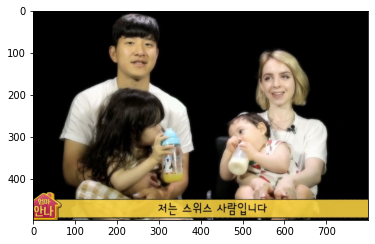

Predicted Caption: woman holding nintendo wii controller


In [ ]:
random(family_path)

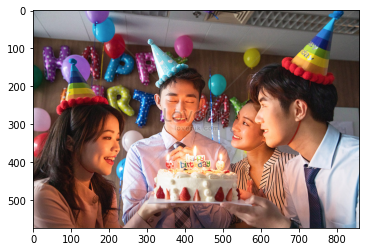

Predicted Caption: group of people sitting around table with cake


In [ ]:
random(peo_path)

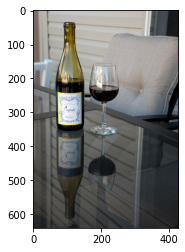

Predicted Caption: wine glasses and wine glasses on table


In [ ]:
random(coco_val_1)

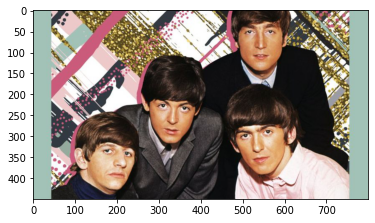

Predicted Caption: woman holding nintendo wii controller


In [ ]:
random(beatles_big)

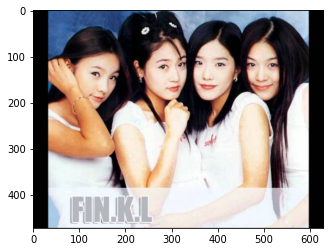

Predicted Caption: woman is sitting on the phone while holding her cell phone


In [ ]:
random(finkl)

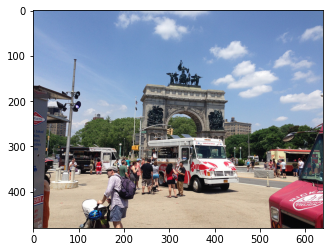

Predicted Caption: man is riding horse down the street


In [ ]:
random(coco_val_2)

## 9. 참고자료



*   https://github.com/jeffheaton/t81_558_deep_learning/blob/master/t81_558_class_10_4_captioning.ipynb
*  https://github.com/HyunJu1/Image-Captioning
